In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torchvision.transforms as transforms
import random

In [3]:
# load dataset
dataset = h5py.File('data/3dshapes.h5', 'r')
print(dataset.keys())
images = dataset['images']  # array shape [480000,64,64,3], uint8 in range(256)
labels = dataset['labels']  # array shape [480000,6], float64
image_shape = images.shape[1:]  # [64,64,3]
label_shape = labels.shape[1:]  # [6]
n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000
_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}

<KeysViewHDF5 ['images', 'labels']>


In [4]:
# Number of samples to select
n_samples_to_select = 50000

# Randomly sample indices from the total number of samples
random_indices = np.random.choice(n_samples, n_samples_to_select, replace=False)
random_indices.sort()
# Select the sampled images and labels
sampled_images = images[random_indices]
sampled_labels = labels[random_indices]


In [5]:
normalized_images = sampled_images / 255.0
normalized_images = normalized_images.transpose(0, 3, 1, 2)
print(normalized_images.shape)

(50000, 3, 64, 64)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim


class VAE(nn.Module):
    def __init__(self, latent_dim=6): # latent dim is 6 because we have 6 factors
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=4, stride=1, padding=0),  # 4x4 -> 1x1
            nn.ReLU(),
        )
        
        # If the final feature map is [batch, latent_dim*2, 1, 1] you can split it into mean and logvar
        # Suppose after last encoder layer, we have latent_dim*2 channels:
        self.fc_mu = nn.Conv2d(256, latent_dim, 1)
        self.fc_logvar = nn.Conv2d(256, latent_dim, 1)
        
        self.decoder = nn.Sequential(
            nn.Conv2d(latent_dim, 256, 1), 
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=1, padding=0), # 1x1 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.Sigmoid()  # Ensures output is within [0,1]
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [15]:
import torch.nn.functional as F

def vae_loss(recon, x, mu, logvar, beta=1.0):
    # we use sigmoid so we use binary cross entropy rather than MSE to provide a better gradient

    # Compute element-wise BCE loss
    bce_per_pixel = F.binary_cross_entropy(recon, x, reduction='none')  # shape [B, C, H, W]
    # Sum over all pixels and channels to get per-image loss
    bce_per_image = bce_per_pixel.sum(dim=[1, 2, 3])  # shape [B]
    # Now average over batch to get one scalar
    recon_loss = bce_per_image.mean()

    # KL divergence term: D_{KL}(q(z|x) || p(z)) = 
    # 0.5 * sum( exp(logvar) + mu^2 - 1 - logvar )
    # KL is computed per image
    kl_per_image = 0.5 * (torch.exp(logvar) + mu**2 - 1.0 - logvar).sum(dim=1).mean() # sum over latent dimensions and then average over batch

    return recon_loss + beta * kl_per_image, recon_loss, kl_per_image


In [16]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Prepare dataset and dataloader
batch_size = 64
tensor_images = torch.tensor(normalized_images, dtype=torch.float32)
dataset = TensorDataset(tensor_images)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Add learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

previous_lr = scheduler.get_last_lr()

In [ ]:
# Training loop
n_epochs = 15
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    running_recon_loss = 0
    running_kl_loss = 0
    for batch in train_loader:
        images = batch[0].to(device)
        optimizer.zero_grad()
        reconstructed, mu, logvar = model(images)
        loss, recon_loss, kl_loss = vae_loss(reconstructed, images, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        running_recon_loss += recon_loss.item()
        running_kl_loss += kl_loss.item()
    train_loss /= len(train_loader)
    avg_recon_loss = running_recon_loss / len(train_loader)
    avg_kl_loss = running_kl_loss / len(train_loader)

    
    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            images = batch[0].to(device)
            reconstructed, mu, logvar = model(images)
            loss, recon_loss, kl_loss = vae_loss(reconstructed, images, mu, logvar)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    # Adjust learning rate
    scheduler.step(val_loss)

    # Check if the learning rate has changed
    current_lr = scheduler.get_last_lr()
    if current_lr != previous_lr:
        print(f"Learning rate changed: {previous_lr} -> {current_lr}")
        previous_lr = current_lr
    
    
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, "
      f"Recon Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}, "
      f"Val Loss: {val_loss:.4f}")


Epoch 1/15, Train Loss: 6014.4338, Recon Loss: 5988.4178, KL Loss: 26.0160, Val Loss: 4317.8376
Epoch 2/15, Train Loss: 4157.5319, Recon Loss: 4122.6989, KL Loss: 34.8329, Val Loss: 4079.6489
Epoch 3/15, Train Loss: 4028.6384, Recon Loss: 3998.7657, KL Loss: 29.8727, Val Loss: 4009.1077


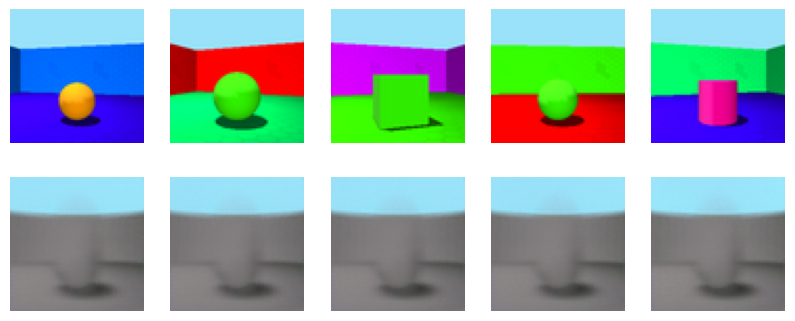

In [13]:
def visualize_reconstruction(model, dataset, n_images=5):
    model.eval()
    indices = random.sample(range(len(dataset)), n_images)
    images = torch.stack([dataset[i][0] for i in indices]).to(device)
    with torch.no_grad():
        reconstructed, _, _, = model(images)  # Unpack only the reconstruction from the output
    
    images = images.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to HWC for visualization
    reconstructed = reconstructed.cpu().numpy().transpose(0, 2, 3, 1)
    
    plt.figure(figsize=(10, 4))
    for i in range(n_images):
        # Original image
        plt.subplot(2, n_images, i+1)
        plt.imshow(images[i])
        plt.axis('off')
        # Reconstructed image
        plt.subplot(2, n_images, i+n_images+1)
        plt.imshow(np.clip(reconstructed[i], 0, 1))  # Ensure valid range
        plt.axis('off')
    plt.show()

# Call visualization function
visualize_reconstruction(model, val_dataset)


In [31]:
# Compute latent stats

val_images = torch.stack([val_dataset[i][0] for i in range(len(val_dataset))])  # Convert dataset to tensor
val_images = val_images.to(device)

batch = val_images[:1000]  # sample first 1000


model.eval()
with torch.no_grad():
    batch = val_images[:1000].to(device)  # sample a portion
    mu, logvar = model.encode(batch)
    mu = mu.squeeze(-1).squeeze(-1)
    mean_z = mu.mean(dim=0)
    std_z = mu.std(dim=0)

model.eval()
with torch.no_grad():
    mu, logvar = model.encode(batch)
    # mu shape: [1000, latent_dim, 1, 1]
    mu = mu.squeeze(-1).squeeze(-1)  # shape [1000, latent_dim]
    mean_z = mu.mean(dim=0)  # shape [latent_dim]
    std_z = mu.std(dim=0)    # shape [latent_dim]

# For each latent dimension, compute variation range as mean ± 3*std
variation_ranges = [(mean_z[i].item() - 3*std_z[i].item(), mean_z[i].item() + 3*std_z[i].item()) 
                    for i in range(model.latent_dim)]
# print("Latent dimension variation ranges: ", variation_ranges)

# Print variation ranges line by line
print("Latent dimension variation ranges:")
for i, (low, high) in enumerate(variation_ranges):
    print(f"Dimension {i + 1}: [{low:.4f}, {high:.4f}]")



Latent dimension variation ranges:
Dimension 1: [-2.3182, 1.8749]
Dimension 2: [-2.9283, 3.1483]
Dimension 3: [-2.7053, 3.3147]
Dimension 4: [-4.0414, 4.1147]
Dimension 5: [-2.4026, 2.5839]
Dimension 6: [-2.5669, 2.2481]
Dimension 7: [-3.4645, 3.8488]
Dimension 8: [-2.9441, 2.8486]
Dimension 9: [-4.7647, 4.8855]
Dimension 10: [-3.1354, 2.8055]


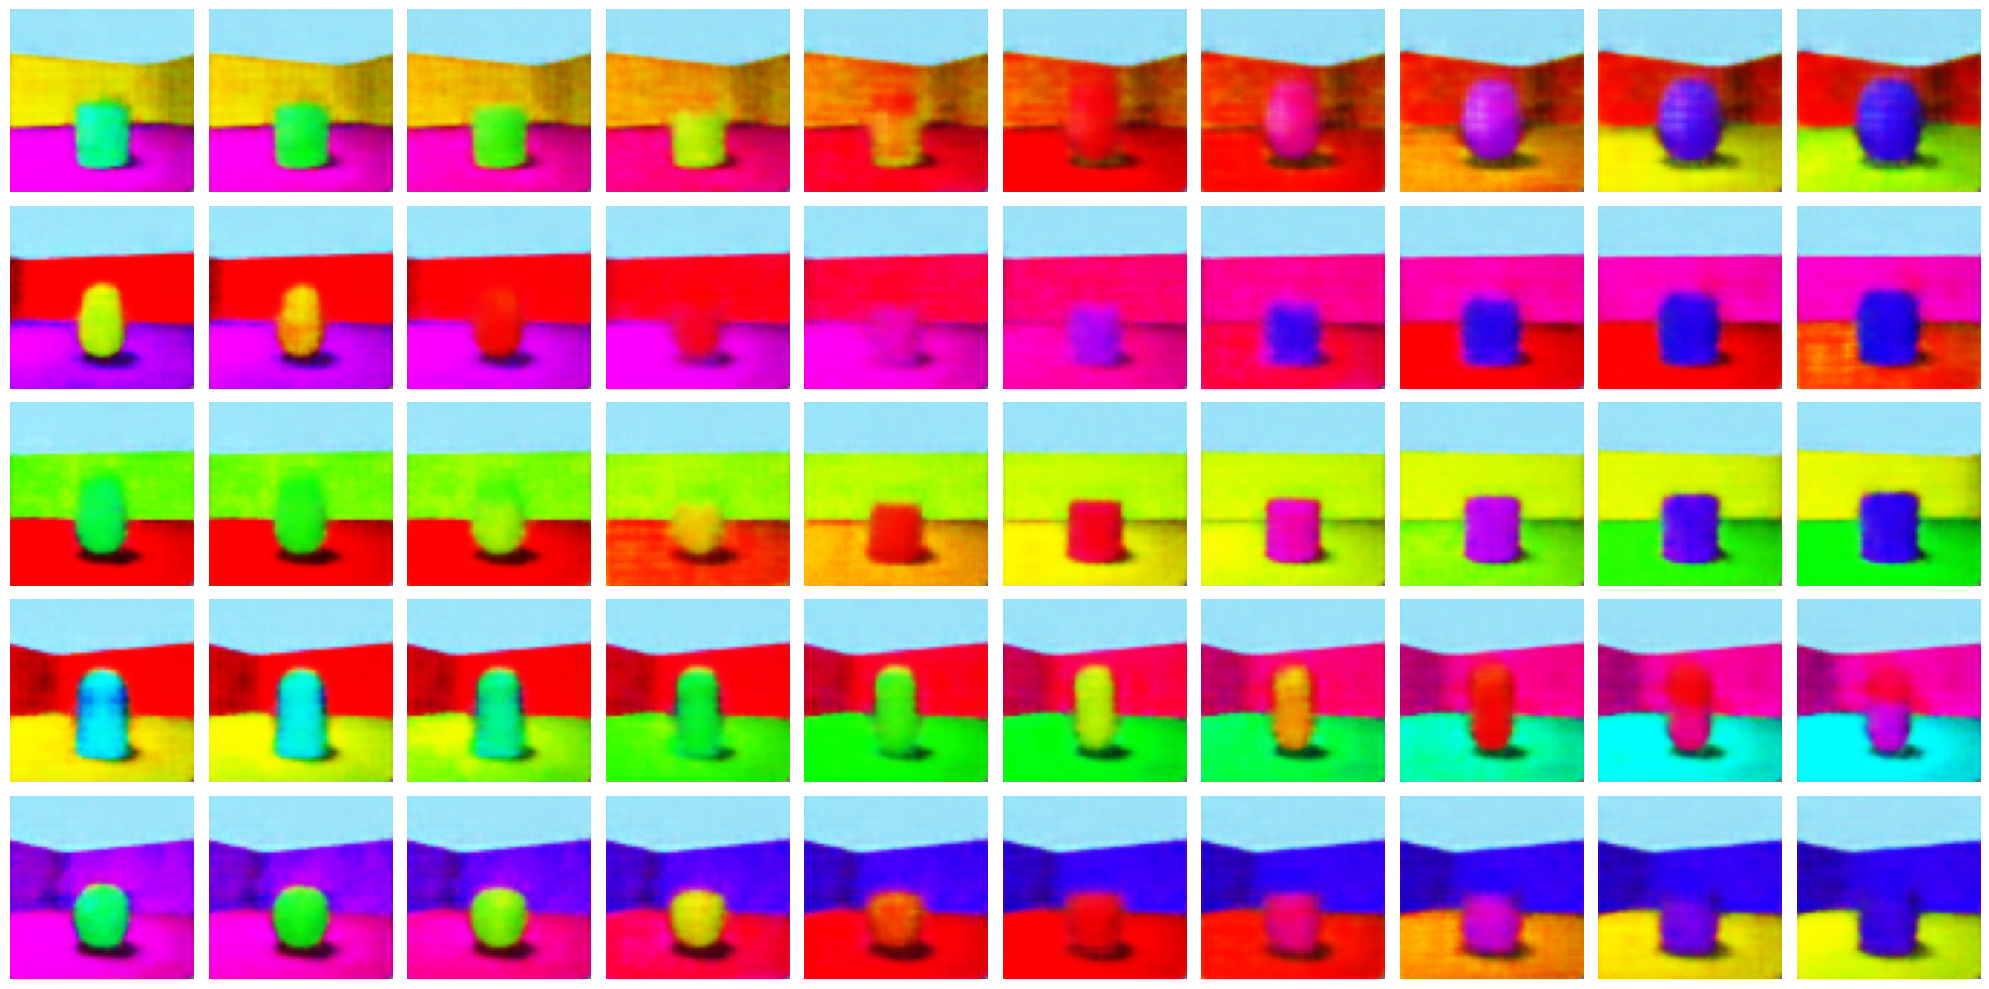

In [35]:
def latent_space_traversal(model, n_samples=5, dim_to_vary=0, variation_range=(-3, 3), steps=10):
    """
    Perform latent space traversal by varying a single dimension of the latent space.
    Parameters:
        model: Trained FactorVAE model.
        n_samples: Number of random samples to use.
        dim_to_vary: Latent dimension to vary.
        variation_range: Tuple indicating the range of variation.
        steps: Number of steps in the variation range.
    """
    model.eval()
    variation_values = torch.linspace(variation_range[0], variation_range[1], steps)
    random_indices = np.random.choice(len(val_dataset), n_samples, replace=False)
    images = torch.stack([val_dataset[i][0] for i in random_indices]).to(device)

    with torch.no_grad():
        # Encode images into latent space
        mu, logvar = model.encode(images)
        std = torch.exp(0.5 * logvar)
        encoded = mu  # Use the mean for traversal
        
        # Flatten the latent space for manipulation
        encoded_flat = encoded.view(n_samples, -1)  # Flatten latent space: [n_samples, latent_dim]
        
        # Prepare a canvas for visualization
        plt.figure(figsize=(steps * 2, n_samples * 2))
        
        for i in range(n_samples):
            base_latent = encoded_flat[i].clone()
            
            for j, value in enumerate(variation_values):
                varied_latent = base_latent.clone()
                varied_latent[dim_to_vary] = value
                
                # Reshape and decode the latent vector
                varied_latent_reshaped = varied_latent.view(1, model.latent_dim, 1, 1)  # [1, latent_dim, 1, 1]
                decoded = model.decoder(varied_latent_reshaped)
                decoded_img = decoded.cpu().squeeze(0).permute(1, 2, 0).numpy()
                
                # Plot the resulting image
                plt.subplot(n_samples, steps, i * steps + j + 1)
                plt.imshow(np.clip(decoded_img, 0, 1))  # Clip to valid range [0, 1]
                plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Perform latent space traversal
latent_space_traversal(model, n_samples=5, dim_to_vary=3, variation_range=(-2, 2), steps=10)


In [2]:
from torchmetrics.image.fid import FrechetInceptionDistance

fid = FrechetInceptionDistance(feature=64).to(device)  # feature=64 or default 2048 if you have enough GPU memory

# Compute FID after training:
model.eval()
real_images_list = []
fake_images_list = []

# Gather a subset of real images from the dataset
subset_indices = np.random.choice(len(val_dataset), 1000, replace=False)
real_images_subset = torch.stack([val_dataset[i][0] for i in subset_indices]).to(device)

with torch.no_grad():
    # Get reconstructed images
    reconstructed_images = []
    for i in range(0, len(real_images_subset), batch_size):
        batch = real_images_subset[i:i+batch_size]
        rec, _, _ = model(batch)
        reconstructed_images.append(rec.cpu())
    reconstructed_images = torch.cat(reconstructed_images, dim=0)

# Add real and reconstructed images to FID:
fid.update(real_images_subset.cpu(), real=True)
fid.update(reconstructed_images, real=False)
fid_score = fid.compute().item()
print(f"FID Score: {fid_score:.4f}")


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /Users/xuroger/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
  3%|▎         | 2.75M/91.2M [00:01<00:44, 2.08MB/s]


KeyboardInterrupt: 